# Importing Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Loading Dataset

In [2]:
df = pd.read_csv("online_retail_II.csv")

In [3]:
# Ensure InvoiceDate is datetime (some CSVs store as string)
if "InvoiceDate" in df.columns:
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
else:
    raise ValueError("Dataset must contain 'InvoiceDate' column.")

print("Rows,Cols:", df.shape)
df.head()

Rows,Cols: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Quick overview & common cleaning

In [4]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


In [7]:
df.shape

(1067371, 8)

In [8]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [10]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

# Missing Values

In [12]:

print("\nMissing values (top):")
display(df.isna().sum().sort_values(ascending=False).head(10))


Missing values (top):


Customer ID    243007
Description      4382
StockCode           0
Invoice             0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

# Data Cleaning

In [13]:
df_clean = df.copy()

In [15]:
# Make sure InvoiceNo is string
df_clean["Invoice"] = df_clean["Invoice"].astype(str)

In [17]:
# Drop rows without CustomerID (we can't segment anonymous without id)
if "Customer ID" in df_clean.columns:
    df_clean = df_clean.dropna(subset=["Customer ID"])
    # CustomerID often floats in the excel file; convert to int
    df_clean["Customer ID"] = df_clean["Customer ID"].astype(int)
else:
    raise ValueError("Dataset must contain 'Customer ID' column.")


C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_16312\1160828985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Customer ID"] = df_clean["Customer ID"].astype(int)


In [18]:
# Remove cancelled invoices (InvoiceNo that start with 'C' indicate cancellation/refund)
df_clean = df_clean[~df_clean["Invoice"].str.startswith("C", na=False)]

In [20]:
# Keep only positive quantity and positive unit price
df_clean = df_clean[(df_clean["Quantity"] > 0) & (df_clean["Price"] > 0)]

In [21]:
# Create total price column
df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]

C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_16312\849199760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["TotalPrice"] = df_clean["Quantity"] * df_clean["Price"]


In [22]:
print("After cleaning Rows,Cols:", df_clean.shape)
df_clean.head()

After cleaning Rows,Cols: (805549, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# Compute RFM metrics

In [23]:
# Set snapshot date for Recency calculation.
# A common choice: one day after the last invoice date in the dataset.
snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)
print("Snapshot date used for Recency:", snapshot_date.date())

# Group by customer and compute:
# Recency = days since last purchase, Frequency = number of distinct invoices, Monetary = total spent
rfm = df_clean.groupby("Customer ID").agg(
    Recency = ("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency = ("Invoice", "nunique"),
    Monetary = ("TotalPrice", "sum")
).reset_index()

# Quick sanity check
rfm.describe().T


Snapshot date used for Recency: 2011-12-10


,count,mean,std,min,25%,50%,75%,max
Customer ID,5878.0,15315.313542,1715.572666,12346.00,13833.2500,15314.500,16797.75,18287.00
Recency,5878.0,201.331916,209.338707,1.00,26.0000,96.000,380.00,739.00
Frequency,5878.0,6.289384,13.009406,1.00,1.0000,3.000,7.00,398.00
Monetary,5878.0,3018.616737,14737.731040,2.95,348.7625,898.915,2307.09,608821.65


# RFM scoring (1-5) — robust approach using quantiles

In [24]:
rfm = rfm.copy()

# Sometimes qcut fails if many identical values -> use .rank() to avoid identical bins
# We'll create rank-based qcuts for Frequency and Monetary, and invert for Recency.
try:
    r_labels = [5,4,3,2,1]  # Recency: most recent -> 5
    rfm["R_Score"] = pd.qcut(rfm["Recency"].rank(method="first"), 5, labels=r_labels).astype(int)
except Exception as e:
    # fallback: bins by cut on rank range
    rfm["R_Score"] = pd.cut(rfm["Recency"].rank(method="first"), bins=5, labels=r_labels).astype(int)

f_labels = [1,2,3,4,5]
m_labels = [1,2,3,4,5]

try:
    rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=f_labels).astype(int)
    rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=m_labels).astype(int)
except Exception as e:
    rfm["F_Score"] = pd.cut(rfm["Frequency"].rank(method="first"), bins=5, labels=f_labels).astype(int)
    rfm["M_Score"] = pd.cut(rfm["Monetary"].rank(method="first"), bins=5, labels=m_labels).astype(int)

# Combine into RFM score fields
rfm["RFM_Score"] = rfm["R_Score"].map(str) + rfm["F_Score"].map(str) + rfm["M_Score"].map(str)
rfm["RFM_Sum"] = rfm["R_Score"] + rfm["F_Score"] + rfm["M_Score"]

rfm.head()


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum
0,12346,326,12,77556.46,2,5,5,255,12
1,12347,2,8,5633.32,5,4,5,545,14
2,12348,75,5,2019.40,3,4,4,344,11
3,12349,19,4,4428.69,5,3,5,535,13
4,12350,310,1,334.40,2,1,2,212,5


# Segment mapping (simple & interpretable)

In [25]:
# We'll define segments using the RFM_Sum (simple) and also label champions by top RFM string
def rfm_segment_from_sum(s):
    if s >= 13:
        return "Champions"
    elif s >= 10:
        return "Loyal Customers"
    elif s >= 8:
        return "Potential / Promising"
    elif s >= 6:
        return "Need Attention"
    else:
        return "At Risk / Lost"

rfm["Segment"] = rfm["RFM_Sum"].apply(rfm_segment_from_sum)

# Additionally mark "Top" customers exactly if they have 5,5,5
rfm.loc[rfm["RFM_Score"] == "555", "Segment"] = "Top - Champions (555)"

# Show distribution
display(rfm["Segment"].value_counts().to_frame("count"))
rfm.head()


,count
Segment,
Loyal Customers,1354
At Risk / Lost,1303
Potential / Promising,979
Need Attention,948
Champions,823
Top - Champions (555),471


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,RFM_Sum,Segment
0,12346,326,12,77556.46,2,5,5,255,12,Loyal Customers
1,12347,2,8,5633.32,5,4,5,545,14,Champions
2,12348,75,5,2019.40,3,4,4,344,11,Loyal Customers
3,12349,19,4,4428.69,5,3,5,535,13,Champions
4,12350,310,1,334.40,2,1,2,212,5,At Risk / Lost


# Visualizations

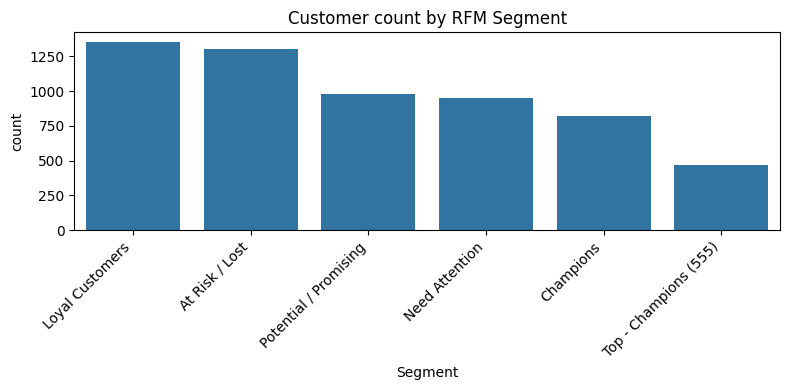

In [26]:
# Count of segments
plt.figure(figsize=(8,4))
order = rfm["Segment"].value_counts().index
sns.countplot(data=rfm, x="Segment", order=order)
plt.xticks(rotation=45, ha="right")
plt.title("Customer count by RFM Segment")
plt.tight_layout()
plt.show()

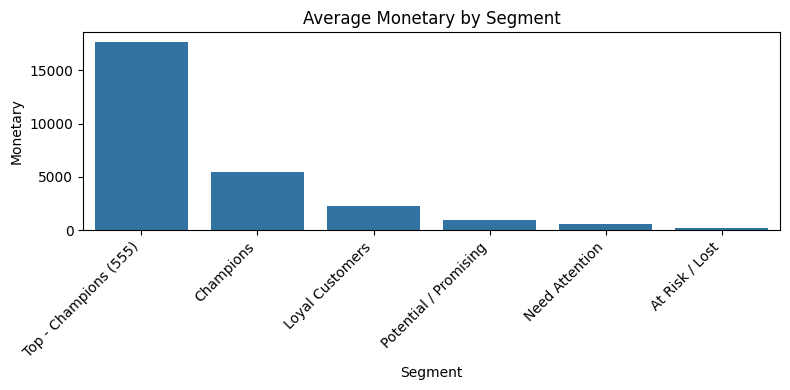

In [27]:
#  Average Monetary and Frequency per segment (bar charts)
seg_stats = rfm.groupby("Segment").agg({"Monetary":"mean", "Frequency":"mean", "Recency":"mean", "RFM_Sum":"mean"}).reset_index()
seg_stats = seg_stats.sort_values("Monetary", ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=seg_stats, x="Segment", y="Monetary")
plt.xticks(rotation=45, ha="right")
plt.title("Average Monetary by Segment")
plt.tight_layout()
plt.show()


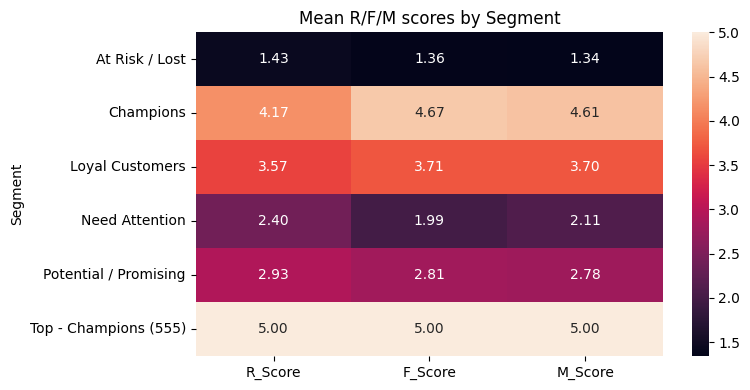

In [28]:
#  Heatmap of mean R,F,M scores by segment (use pivot)
rfm_scores = rfm.groupby("Segment")[["R_Score","F_Score","M_Score"]].mean().round(2)
plt.figure(figsize=(8,4))
sns.heatmap(rfm_scores, annot=True, fmt=".2f")
plt.title("Mean R/F/M scores by Segment")
plt.tight_layout()
plt.show()

# Top customers / export results

In [30]:
# Top 10 customers by Monetary
top10 = rfm.sort_values("Monetary", ascending=False).head(10)
display(top10[["Customer ID","Monetary","Frequency","Recency","RFM_Score","Segment"]])

# Save full RFM table for later use
rfm.to_csv("rfm_customers.csv", index=False)
print("Saved: rfm_customers.csv")


,Customer ID,Monetary,Frequency,Recency,RFM_Score,Segment
5692,18102,608821.65,145,1,555,Top - Champions (555)
2277,14646,528602.52,151,2,555,Top - Champions (555)
1789,14156,313946.37,156,10,555,Top - Champions (555)
2538,14911,295972.63,398,1,555,Top - Champions (555)
5050,17450,246973.09,51,8,555,Top - Champions (555)
1331,13694,196482.81,143,4,555,Top - Champions (555)
5109,17511,175603.55,60,3,555,Top - Champions (555)
4061,16446,168472.50,2,1,525,Loyal Customers
4295,16684,147142.77,55,4,555,Top - Champions (555)
68,12415,144458.37,28,24,455,Champions


Saved: rfm_customers.csv


# Simple marketing ideas for each segment

# K_Means

In [32]:
rfm_k = rfm[["Recency","Frequency","Monetary"]].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_k)

# KMeans with k=4 (example)
k = 4
km = KMeans(n_clusters=k, random_state=42)
rfm["KMeansCluster"] = km.fit_predict(rfm_scaled)
rfm.groupby("KMeansCluster").agg({"Monetary":"mean","Frequency":"mean","Recency":"mean","Customer ID":"count"}).round(2)


,Monetary,Frequency,Recency,Customer ID
KMeansCluster,,,,
0,765.24,2.21,463.03,1998
1,3009.40,7.31,67.01,3841
2,83086.08,103.71,25.94,35
3,436835.79,212.50,3.50,4
